In [76]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=16, optimizer_generator = SGD(0.001, momentum=.9), 
                optimizer_discriminator = SGD(0.0001, momentum=.9), optimizer_autoencoder = Adam(0.0001)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, \
                self.discriminator2, self.generator, self.generator2 = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        #encoder.add(GlobalAvgPool3D())
        encoder.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Flatten())
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dense(512, activation="relu"))
        encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
        decoder.add(Dense(256, activation='relu', input_dim=encoded_dim))
        decoder.add(Dense(256, activation='relu'))
        decoder.add(Dense(6*12*12, activation='relu'))
        #decoder.add(Reshape([12*24*24,1]))
        #decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
        #decoder.add(Permute((2,1)))
        decoder.add(Reshape([6,12,12,1]))
        decoder.add(Conv3DTranspose(filters=128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(1024, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(1024, activation="relu"))
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator
    
    def _buildDiscriminator2(self, img_shape):
        
        discriminator = Sequential()
        discriminator.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        #discriminator.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        #discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(Dropout(0.2))
        discriminator.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        discriminator.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #discriminator.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        discriminator.add(GlobalAvgPool3D())
        #discriminator.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        discriminator.add(Flatten())
        discriminator.add(Dense(128, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))
        
        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape) # this is the input for autoencoder and main generator
        decoder_input=Input(shape=encoded_dim)
        
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mse")

        discriminator=self._buildDiscriminator(encoded_dim)
        discriminator.trainable = False
        generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
        generator.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator.trainable = True
        discriminator.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
    
        discriminator2 = self._buildDiscriminator2(img_shape)
        discriminator2.trainable = False
        generator2=Model(decoder_input, discriminator2(decoder(decoder_input)))
        generator2.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator2.trainable = True
        discriminator2.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
        
        return encoder, decoder, autoencoder, discriminator, discriminator2, generator, generator2

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        discriminator2_losses = []
        generator_losses = []
        generator2_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            fake_image = self.decoder.predict(fake_latent)
            
            discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
            discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator2_input = np.concatenate((fake_image, x))
            discriminator2_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            discriminator2_history = self.discriminator2.train_on_batch(discriminator2_input, discriminator2_labels)
            generator2_history = self.generator2.train_on_batch(fake_latent, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            discriminator2_losses.append(discriminator2_history)
            generator_losses.append(generator_history)
            generator2_losses.append(generator2_history)

            if epoch % 50 == 0:
                self.autoencoder.save("../GAN_log/autoencoder_epoch_{}.h5".format(epoch))
                #self.discriminator.save("../GAN_log/discriminator_epoch_{}.h5".format(epoch))
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  D1_loss:{:.3f}   D2_loss:{:.3f}   G1_loss:{:.3f}   G2_loss:{:.3f}".format(
                autoencoder_history, discriminator_history, discriminator2_history, generator_history, generator2_history
                )
            )

        self.history = {
                        'AE_loss':autoencoder_losses, 
                        'D1_loss':discriminator_losses, 
                        'D2_loss':discriminator2_losses, 
                        'G1_loss':generator_losses,
                        'G2_loss':generator2_losses
                       }
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [77]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

model = AAE(encoded_dim=128)

import os
import SimpleITK as sitk 

datapath = r'../100x100x48 niis'
file_reference = r'../File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

batch_size=8
n_epochs=500
seed=42
np.random.seed(42)

history = model.train(train_set, batch_size, n_epochs, len(img_ls))

100%|██████████| 1198/1198 [00:07<00:00, 153.44it/s]


Epoch--1
AE_loss: 0.0245  D1_loss:0.676   D2_loss:0.685   G1_loss:0.693   G2_loss:0.693
Epoch--2
AE_loss: 0.0234  D1_loss:0.654   D2_loss:0.685   G1_loss:0.693   G2_loss:0.693
Epoch--3
AE_loss: 0.0308  D1_loss:0.662   D2_loss:0.683   G1_loss:0.693   G2_loss:0.693
Epoch--4
AE_loss: 0.0362  D1_loss:0.635   D2_loss:0.682   G1_loss:0.693   G2_loss:0.693
Epoch--5
AE_loss: 0.0257  D1_loss:0.643   D2_loss:0.683   G1_loss:0.693   G2_loss:0.693
Epoch--6
AE_loss: 0.0320  D1_loss:0.632   D2_loss:0.682   G1_loss:0.693   G2_loss:0.693
Epoch--7
AE_loss: 0.0294  D1_loss:0.639   D2_loss:0.683   G1_loss:0.693   G2_loss:0.693
Epoch--8
AE_loss: 0.0299  D1_loss:0.621   D2_loss:0.683   G1_loss:0.693   G2_loss:0.693
Epoch--9
AE_loss: 0.0270  D1_loss:0.657   D2_loss:0.683   G1_loss:0.692   G2_loss:0.693
Epoch--10
AE_loss: 0.0308  D1_loss:0.638   D2_loss:0.683   G1_loss:0.692   G2_loss:0.693
Epoch--11
AE_loss: 0.0274  D1_loss:0.636   D2_loss:0.683   G1_loss:0.692   G2_loss:0.693
Epoch--12
AE_loss: 0.0259  D1_

Epoch--94
AE_loss: 0.0300  D1_loss:1.089   D2_loss:0.683   G1_loss:0.193   G2_loss:0.686
Epoch--95
AE_loss: 0.0261  D1_loss:1.144   D2_loss:0.685   G1_loss:0.176   G2_loss:0.686
Epoch--96
AE_loss: 0.0274  D1_loss:1.197   D2_loss:0.683   G1_loss:0.158   G2_loss:0.686
Epoch--97
AE_loss: 0.0292  D1_loss:1.280   D2_loss:0.684   G1_loss:0.141   G2_loss:0.686
Epoch--98
AE_loss: 0.0288  D1_loss:1.312   D2_loss:0.684   G1_loss:0.124   G2_loss:0.686
Epoch--99
AE_loss: 0.0242  D1_loss:1.396   D2_loss:0.684   G1_loss:0.108   G2_loss:0.686
Epoch--100
AE_loss: 0.0282  D1_loss:1.477   D2_loss:0.682   G1_loss:0.094   G2_loss:0.686
Epoch--101
AE_loss: 0.0285  D1_loss:1.556   D2_loss:0.683   G1_loss:0.082   G2_loss:0.687
Epoch--102
AE_loss: 0.0286  D1_loss:1.613   D2_loss:0.683   G1_loss:0.074   G2_loss:0.687
Epoch--103
AE_loss: 0.0290  D1_loss:1.626   D2_loss:0.682   G1_loss:0.078   G2_loss:0.687
Epoch--104
AE_loss: 0.0267  D1_loss:1.569   D2_loss:0.683   G1_loss:0.089   G2_loss:0.687
Epoch--105
AE_lo

Epoch--186
AE_loss: 0.0203  D1_loss:0.770   D2_loss:0.682   G1_loss:0.726   G2_loss:0.684
Epoch--187
AE_loss: 0.0185  D1_loss:0.827   D2_loss:0.683   G1_loss:0.725   G2_loss:0.683
Epoch--188
AE_loss: 0.0208  D1_loss:0.801   D2_loss:0.682   G1_loss:0.724   G2_loss:0.683
Epoch--189
AE_loss: 0.0189  D1_loss:0.833   D2_loss:0.683   G1_loss:0.723   G2_loss:0.683
Epoch--190
AE_loss: 0.0176  D1_loss:0.779   D2_loss:0.684   G1_loss:0.723   G2_loss:0.682
Epoch--191
AE_loss: 0.0192  D1_loss:0.773   D2_loss:0.684   G1_loss:0.722   G2_loss:0.682
Epoch--192
AE_loss: 0.0205  D1_loss:0.799   D2_loss:0.683   G1_loss:0.721   G2_loss:0.682
Epoch--193
AE_loss: 0.0164  D1_loss:0.782   D2_loss:0.684   G1_loss:0.721   G2_loss:0.682
Epoch--194
AE_loss: 0.0193  D1_loss:0.774   D2_loss:0.684   G1_loss:0.720   G2_loss:0.682
Epoch--195
AE_loss: 0.0196  D1_loss:0.763   D2_loss:0.683   G1_loss:0.720   G2_loss:0.682
Epoch--196
AE_loss: 0.0192  D1_loss:0.773   D2_loss:0.683   G1_loss:0.719   G2_loss:0.682
Epoch--197

Epoch--278
AE_loss: 0.0210  D1_loss:0.630   D2_loss:0.683   G1_loss:0.677   G2_loss:0.679
Epoch--279
AE_loss: 0.0199  D1_loss:0.651   D2_loss:0.683   G1_loss:0.676   G2_loss:0.678
Epoch--280
AE_loss: 0.0186  D1_loss:0.628   D2_loss:0.686   G1_loss:0.676   G2_loss:0.678
Epoch--281
AE_loss: 0.0166  D1_loss:0.613   D2_loss:0.686   G1_loss:0.675   G2_loss:0.678
Epoch--282
AE_loss: 0.0196  D1_loss:0.644   D2_loss:0.683   G1_loss:0.675   G2_loss:0.678
Epoch--283
AE_loss: 0.0190  D1_loss:0.629   D2_loss:0.684   G1_loss:0.675   G2_loss:0.678
Epoch--284
AE_loss: 0.0162  D1_loss:0.657   D2_loss:0.685   G1_loss:0.674   G2_loss:0.679
Epoch--285
AE_loss: 0.0198  D1_loss:0.618   D2_loss:0.683   G1_loss:0.674   G2_loss:0.680
Epoch--286
AE_loss: 0.0165  D1_loss:0.615   D2_loss:0.684   G1_loss:0.674   G2_loss:0.682
Epoch--287
AE_loss: 0.0189  D1_loss:0.614   D2_loss:0.683   G1_loss:0.673   G2_loss:0.682
Epoch--288
AE_loss: 0.0234  D1_loss:0.618   D2_loss:0.681   G1_loss:0.673   G2_loss:0.681
Epoch--289

Epoch--370
AE_loss: 0.0198  D1_loss:0.577   D2_loss:0.684   G1_loss:0.639   G2_loss:0.674
Epoch--371
AE_loss: 0.0195  D1_loss:0.540   D2_loss:0.683   G1_loss:0.639   G2_loss:0.674
Epoch--372
AE_loss: 0.0176  D1_loss:0.563   D2_loss:0.683   G1_loss:0.638   G2_loss:0.675
Epoch--373
AE_loss: 0.0190  D1_loss:0.579   D2_loss:0.682   G1_loss:0.638   G2_loss:0.676
Epoch--374
AE_loss: 0.0188  D1_loss:0.568   D2_loss:0.682   G1_loss:0.638   G2_loss:0.678
Epoch--375
AE_loss: 0.0193  D1_loss:0.570   D2_loss:0.683   G1_loss:0.638   G2_loss:0.681
Epoch--376
AE_loss: 0.0198  D1_loss:0.569   D2_loss:0.680   G1_loss:0.637   G2_loss:0.682
Epoch--377
AE_loss: 0.0181  D1_loss:0.560   D2_loss:0.681   G1_loss:0.637   G2_loss:0.682
Epoch--378
AE_loss: 0.0173  D1_loss:0.555   D2_loss:0.682   G1_loss:0.637   G2_loss:0.681
Epoch--379
AE_loss: 0.0193  D1_loss:0.562   D2_loss:0.681   G1_loss:0.636   G2_loss:0.678
Epoch--380
AE_loss: 0.0159  D1_loss:0.549   D2_loss:0.684   G1_loss:0.636   G2_loss:0.675
Epoch--381

Epoch--462
AE_loss: 0.0185  D1_loss:0.532   D2_loss:0.682   G1_loss:0.620   G2_loss:0.681
Epoch--463
AE_loss: 0.0176  D1_loss:0.526   D2_loss:0.682   G1_loss:0.620   G2_loss:0.681
Epoch--464
AE_loss: 0.0197  D1_loss:0.535   D2_loss:0.681   G1_loss:0.620   G2_loss:0.681
Epoch--465
AE_loss: 0.0182  D1_loss:0.531   D2_loss:0.679   G1_loss:0.620   G2_loss:0.678
Epoch--466
AE_loss: 0.0168  D1_loss:0.525   D2_loss:0.684   G1_loss:0.620   G2_loss:0.678
Epoch--467
AE_loss: 0.0151  D1_loss:0.544   D2_loss:0.684   G1_loss:0.620   G2_loss:0.678
Epoch--468
AE_loss: 0.0179  D1_loss:0.564   D2_loss:0.681   G1_loss:0.620   G2_loss:0.677
Epoch--469
AE_loss: 0.0176  D1_loss:0.518   D2_loss:0.680   G1_loss:0.620   G2_loss:0.676
Epoch--470
AE_loss: 0.0211  D1_loss:0.534   D2_loss:0.681   G1_loss:0.620   G2_loss:0.676
Epoch--471
AE_loss: 0.0171  D1_loss:0.546   D2_loss:0.681   G1_loss:0.620   G2_loss:0.675
Epoch--472
AE_loss: 0.0175  D1_loss:0.537   D2_loss:0.684   G1_loss:0.620   G2_loss:0.677
Epoch--473

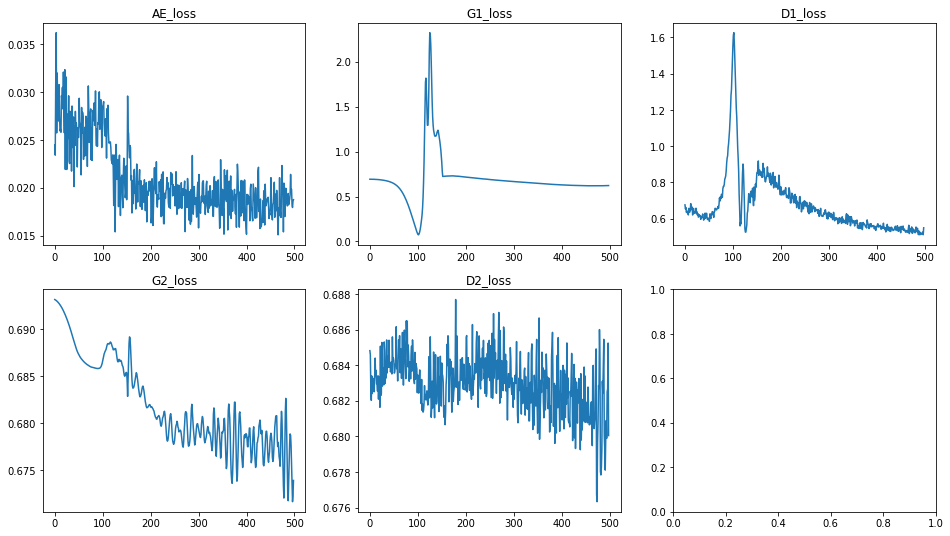

In [78]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 3, figsize=(16,9))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G1_loss"], label="G1_loss")
ax[0, 1].set_title("G1_loss")

ax[0, 2].plot(range(n_epochs-1), history["D1_loss"], label="D1_loss")
ax[0, 2].set_title("D1_loss")

ax[1, 0].plot(range(n_epochs-1), history["G2_loss"], label="G2_loss")
ax[1, 0].set_title("G2_loss")

ax[1, 1].plot(range(n_epochs-1), history["D2_loss"], label="D2_loss")
ax[1, 1].set_title("D2_loss")

plt.show()

In [85]:
image = train_set[4].reshape((1,48,96,96,1))
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

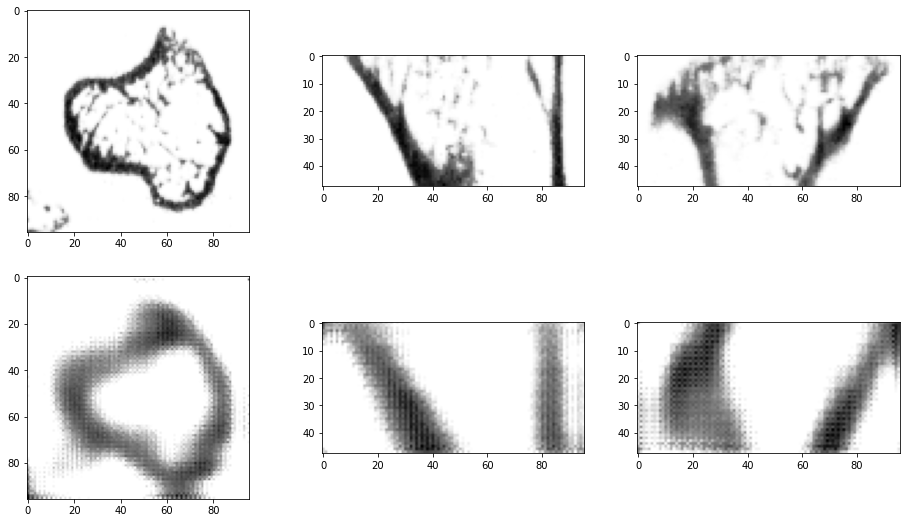

In [86]:
fig2, ax = plt.subplots(2,3, figsize=(16,9))
ax[0,0].imshow(image[35,:,:],cmap="Greys")
ax[1,0].imshow(gen_image[35,:,:],cmap="Greys")
ax[0,1].imshow(image[::-1,50,:],cmap="Greys")
ax[1,1].imshow(gen_image[::-1,50,:],cmap="Greys")
ax[0,2].imshow(image[::-1,:,60],cmap="Greys")
ax[1,2].imshow(gen_image[::-1,:,60],cmap="Greys")

In [75]:
#model = AAE(encoded_dim=256)
model.encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_96 (Conv3D)           (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 24, 48, 48, 16)    6928      
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_99 (Conv3D)           (None, 12, 24, 24, 32)    27680     
_________________________________________________________________
conv3d_100 (Conv3D)          (None, 12, 24, 24, 64)    55360     
_________________________________________________________________
conv3d_101 (Conv3D)          (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_102 (Conv3D)          (None, 6, 12, 12, 128)  

In [74]:
model.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_100 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_101 (Dense)            (None, 13824)             3552768   
_________________________________________________________________
reshape_8 (Reshape)          (None, 3, 6, 6, 128)      0         
_________________________________________________________________
conv3d_transpose_56 (Conv3DT (None, 3, 6, 6, 64)       221248    
_________________________________________________________________
conv3d_transpose_57 (Conv3DT (None, 6, 12, 12, 64)     110656    
_________________________________________________________________
conv3d_transpose_58 (Conv3DT (None, 6, 12, 12, 32)   

In [44]:
model.discriminator2.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_103 (Conv3D)          (None, 48, 96, 96, 16)    448       
_________________________________________________________________
conv3d_104 (Conv3D)          (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_43 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
conv3d_106 (Conv3D)          (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 12, 24, 24, 32)    0         
_________________________________________________________________
conv3d_107 (Conv3D)          (None, 12, 24, 24, 64)  

In [52]:
for layer in model.generator.layers:
    print(layer.trainable)

True
True
True


In [57]:
model.generator2.summary()

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
sequential_50 (Sequential)   (None, 48, 96, 96, 1)     2219409   
_________________________________________________________________
sequential_52 (Sequential)   (None, 1)                 69729     
Total params: 2,219,409
Trainable params: 2,219,409
Non-trainable params: 0
_________________________________________________________________
